In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from torch import optim
from torchvision import transforms
from torchvision import datasets

In [2]:
data_path = "../data-unverioned/p1c7/"
cifar10 = datasets.CIFAR10(data_path, train=True,
                          download=True,
                          transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=(0.4915, 0.4823, 0.4468),
                                std=(0.4915, 0.4823, 0.4468))]))
                           
cifar10_val = datasets.CIFAR10(data_path, train=False,
                          download=True,
                          transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=(0.4943, 0.4852, 0.4506),
                                std=(0.2467, 0.2429, 0.2616))]))

Files already downloaded and verified
Files already downloaded and verified


The torch.nn module provides convolutions for 1, 2, and 3 dimensions: nn.Conv1d for time series, nn.Conv2d for images, and nn.Conv3d for volumes or videos.
For our CIFAR-10 data, we’ll resort to nn.Conv2d. At a minimum, the arguments we
provide to nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output
features, and the size of the kernel. 

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution,it means 3 × 3 (provided as a tuple (3, 3) in Python). For a 3D convolution, it means 3 × 3 × 3.

#### Defining the convolution layer

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3) # 3 input channel depth 16 output channel depth
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? The kernel is of size 3 × 3, so
we want the weight to consist of 3 × 3 parts. For a single output pixel value, our kernel
would consider, say, in_ch = 3 input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape in_ch × 3 × 3. Finally, we have as many of those as we have output channels,
here out_ch = 16, so the complete weight tensor is out_ch × in_ch × 3 × 3, in our case
16 × 3 × 3 × 3. The bias will have size 16.

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input:

In [5]:
img, _ = cifar10[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

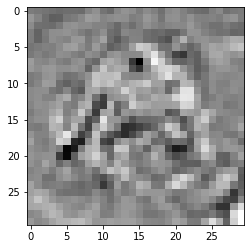

In [6]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

PyTorch gives us the possibility of padding the image by creating ghost pixels
around the border that have value zero as far as the convolution is concerned. Figure
8.3 shows padding in action: In our case, specifying padding=1 when kernel_size=3 means i00 has an extra set of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image. The net result is that the output has now the exact same size as the input:

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [8]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Note that the sizes of weight and bias don’t change, regardless of whether padding is
used.

Let’s first zero out bias, just to remove any confounding factors, and then set
weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood:

In [9]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0/9.0)

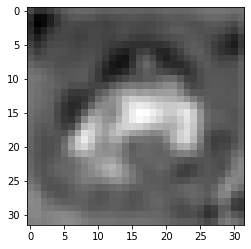

In [10]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

#### Max pooling
Max pooling is provided by the nn.MaxPool2d module (as with convolution, there are
versions for 1D and 3D data). It takes as input the size of the neighborhood over which
to operate the pooling operation. If we wish to downsample our image by half, we’ll want
to use a size of 2. Let’s verify that it works as expected directly on our input image:

In [11]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### Bulding simple CNN

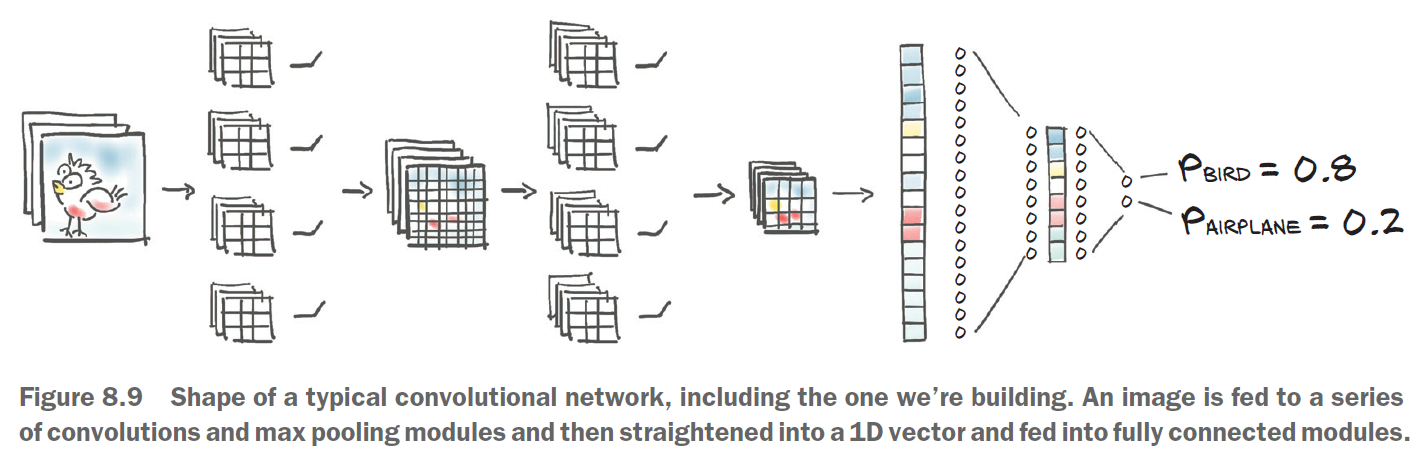

In [12]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      # ..... Mising flatten function/layer
                      nn.Linear(8*8*8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

In [13]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [14]:
model(img.unsqueeze(0))
# the model throws eroor due to flatten layer

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at ..\aten\src\TH/generic/THTensorMath.cpp:41

At some point in developing neural networks, we will find ourselves in a situation where
we want to compute something that the premade modules do not cover. Here, it is something
very simple like reshaping,5; but in section 8.5.3, we use the same construction to
implement residual connections. So in this section, we learn how to make our own
nn.Module subclasses that we can then use just like the prebuilt ones or nn.Sequential.

In order to subclass nn.Module, at a minimum we need to define a forward function
that takes the inputs to the module and returns the output. This is where we define our
module’s computation. The name forward here is reminiscent of a distant past, when
modules needed to define both the forward and backward passes we met in section
5.5.1. With PyTorch, if we use standard torch operations, autograd will take care of the
backward pass automatically; and indeed, an nn.Module never comes with a backward.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor
__init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call super().__init__() before you can do that (or PyTorch will remind you

### Creating a own network as an nn.Module

To do so, we instantiate all the nn.Conv2d, nn.Linear, and so on that we previously passed to nn.Sequential in the constructor, and then use their instances one after another in forward:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

The Net class is equivalent to the nn.Sequential model we built earlier in terms of submodules; but by writing the forward function explicitly, we can manipulate the
output of self.pool3 directly and call view on it to turn it into a B × N vector. Note that we leave the batch dimension as –1 in the call to view, since in principle we
don’t know how many samples will be in the batch. 

In [ ]:
model = Net()
model

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Indeed, torch .nn.functional provides many functions that work like the modules we find in nn. But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call.
For instance, the functional counterpart of nn.Linear is nn.functional.linear, which is a function that has signature linear(input, weight, bias=None). The weight and bias parameters are arguments to the function.

In [17]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Whether to use the functional or the modular API is a decision based on style and
taste. When part of a network is so simple that we want to use nn.Sequential, we’re in
the modular realm. When we are writing our own forwards, it may be more natural to
use the functional interface for things that do not need state in the form of parameters

#### Training the CNN

In [5]:
def training_loop(n_epoch, model, loos_fn, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(device)
    for epoch in range(1, n_epoch+1):
        loss_train = 0.0
        
        for img,label in train_loader:
            img, target = img.to(device), label.to(device)
            
            ouput = model(img)
            
            loss = loos_fn(ouput, target)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print("Epoch:%d Training loss:%.4f" %(epoch, loss_train/len(train_loader)))

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [ ]:
len(cifar2), len(cifar2_val)

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epoch = 100,
             optimizer = optimizer,
             model = model,
             loos_fn = loss_fn,
             train_loader = train_loader)

#### Measuring accuracy

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)

def validate(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for img, label in val_loader:
            img, target = img.to(device), label.to(device)
            
            output = model(img)
            _, pred = torch.max(output, dim=1)
            total += label.shape[0]
            correct += int((pred==target).sum())
            
    print("Accuracy: {:.2f}".format(correct/total))

In [ ]:
validate(model=model, val_loader=val_loader)

#### Saving and loading the model
The birds_vs_airplanes.pt file now contains all the parameters of model: that is, weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production for our friend, we’ll need to keep the model class handy, create an instance, and then load the parameters back into it:

In [22]:
torch.save(model.state_dict(), data_path+'birds_vs_airplane.pt')

In [23]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path+'birds_vs_airplane.pt'))

<All keys matched successfully>

There is a slight complication when loading network weights: PyTorch will attempt
to load the weight to the same device it was saved from—that is, weights on the GPU
will be restored to the GPU. As we don’t know whether we want the same device, we
have two options: we could move the network to the CPU before saving it, or move it
back after restoring. It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the map_location keyword
argument to torch.load:

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplane.pt',
                                       map_location=device))

<All keys matched successfully>

#### Adding memory capacity

In [7]:
class Netwidth(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 16, 3, 1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv1(out)), 2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily pass a parameter to init and parameterize the width, taking care to also parameterize the call to view in the forward function

In [19]:
class Netwidth(nn.Module):
    
    def __init__(self, n_chans1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans1*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv1(out)), 2)
        out = out.view(-1, n_chans1//2*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
# Number of parameters in the model
model = Netwidth(n_chans1=16)
sum(p.numel() for p in model.parameters())

34474

The greater the capacity, the more variability in the inputs the model will be able to manage; but at the same time, the more likely overfitting will be, since the model can use a greater number of parameters to memorize unessential aspects of the input.

#### Helping our model to converge and generalize: Regularization
The most popular regularization terms of this kind are L2 regularization, which is the sum of squares of all weights in the model, and L1 regularization, which is the sum of the absolute values of all weights in the model. L2 regularization is also referred to as weight decay. Note that weight decay applies to all parameters of the network, such as biases.

In PyTorch, we could implement regularization pretty easily by adding a term to the loss. After computing the loss, whatever the loss function is, we can iterate the parameters of the model, sum their respective square (for L2) or abs (for L1), and backpropagate:

In [25]:
def training_loop_l2reg(n_epochs, optimizer, model,
                        loss_fn, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    l2_lambda = 0.00
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        for img, label in train_loader:
            img, traget = img.to(device)
            
            output = model(img)
            loss = loss_fn(output, target)
            
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            # Replaces pow(2.0) with abs() for L1 regularization
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss
        
        print("Epoch:%d, Training Loss:%.4f" %(epoch, train_loss))
            

#### NOT RELYING TOO MUCH ON A SINGLE INPUT: DROPOUT
In PyTorch, we can implement dropout in a model by adding an nn.Dropout module between the nonlinear activation function and the linear or convolutional module of the subsequent layer. As an argument, we need to specify the probability with whichinputs will be zeroed out. In case of convolutions, we’ll use the specialized **nn.Dropout2d** or **nn.Dropout3d**, which zero out entire channels of the input:

In [26]:
class Netwidth(nn.Module):
    
    def __init__(self, n_chans1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(n_chans1*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv1(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, n_chans1//2*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Note that dropout is normally active during training, while during the evaluation of a trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero. This is controlled through the train property of the Dropout module. Recall that PyTorch lets us switch between the two modalities by calling:

__model.train()__ or __model.eval()__

The call will be automatically replicated on the submodules so that if Dropout is among them, it will behave accordingly in subsequent forward
and backward passes.

#### KEEPING ACTIVATIONS IN CHECK: BATCH NORMALIZATION
In practical terms, batch normalization shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of the minibatch.

Batch normalization in PyTorch is provided through the nn.BatchNorm1D,
nn.BatchNorm2d, and nn.BatchNorm3d modules, depending on the imensionality of the input. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution, in this case) and the activation, as shown here

In [30]:
class NetBatchNorm(nn.Module):
    
    def __init__(self, n_chanls=32):
        super().__init()
        self.n_chanls = chanls
        self.conv1 = nn.Conv2d(3, n_chanls, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chanls)
        self.conv2 = nn.Conv2d(n_chanls, n_chanls//2, kernel_size, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chanls//2)
        self.fc1 = nn.Linear(8*8*n_chanls//2, 32)
        self.fc2= nn.Linear(32, 2)
                            
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out, 2))
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8*8*self.n_chanls//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

As minibatches are processed, in addition to estimating the mean and standard deviation for the current minibatch, PyTorch also updates the running estimates for mean and standard deviation that are representative of the whole dataset, as an approximation. This way, when the user specifies model.eval() and the model contains a batch normalization module, the running estimates are frozen and used for normalization. To unfreeze running estimates and return to using the minibatch statistics, we call model.train(), just as we did for dropout.

### Adding Skip connections to the Network similar to ResNet
A skip connection is nothing but the addition of the input to the output
of a block of layers. This is exactly how it is done in PyTorch. Let’s add one layer to our simple convolutional model, and let’s use ReLU as the activation for a change.

In [4]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class NetDepth(nn.Module):
    def __init__(self, n_chanls):
        super().__init__()
        self.n_chanels = n_chanls
        self.conv1 = nn.Conv2d(3, n_chanls, 3, 1)
        self.conv2 = nn.Conv2d(n_chanls, n_chanls//2, 3, 1)
        self.conv3 = nn.Conv2d(n_chanls//2, n_chanls//2, 3, 1)
        self.fc1 = nn.Linear(4*4*n_chanls//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x), 2))
        out = F.max_pool2d(torch.relu(self.conv2(out), 2))
        out = F.max_pool2d(torch.relu(self.conv3(out), 2))
        out = out.view(-1, 4*4*n_chanls//2)
        out = torch.relu(self.fc1(out), 2)
        out = self.fc2(out)
        return out

In [9]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class NetDepth(nn.Module):
    def __init__(self, n_chanls):
        super().__init__()
        self.n_chanels = n_chanls
        self.conv1 = nn.Conv2d(3, n_chanls, 3, 1)
        self.conv2 = nn.Conv2d(n_chanls, n_chanls//2, 3, 1)
        self.conv3 = nn.Conv2d(n_chanls//2, n_chanls//2, 3, 1)
        self.fc1 = nn.Linear(4*4*n_chanls//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x), 2))
        out = F.max_pool2d(torch.relu(self.conv2(out), 2))
        out1 = out
        # adding skip connection
        out = F.max_pool2d(torch.relu(self.conv3(out) + out1, 2))
        out = out.view(-1, 4*4*n_chanls//2)
        out = torch.relu(self.fc1(out), 2)
        out = self.fc2(out)
        return out

### Building Very Deep Models
The standard strategy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip connection block, and then build the network dynamically in a for loop.
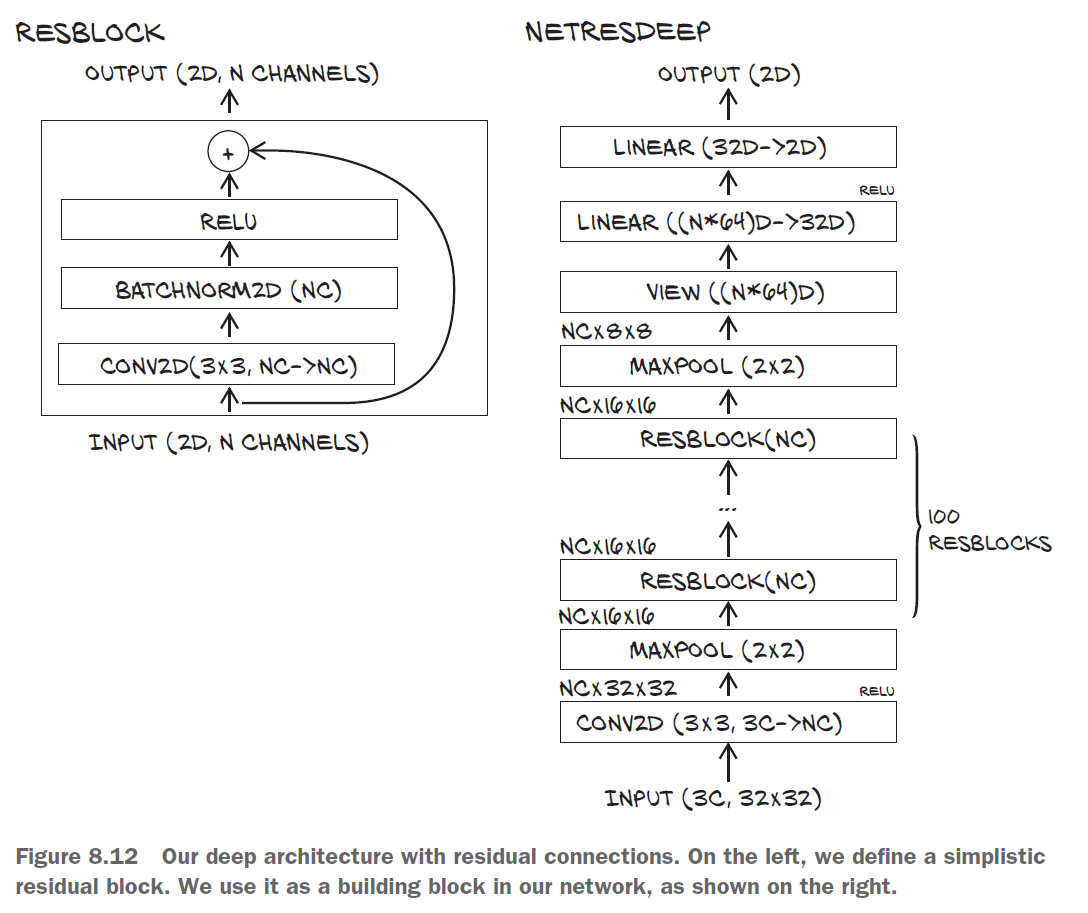

In [11]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, 3, 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                     nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

First, in init, we create nn.Sequential containing a list of ResBlock instances. __nn.Sequential__ will ensure that the output of one block is used as input to the next. It will also ensure that all the parameters in the block are visible to Net. Then, in forward, we just call the sequential to traverse the 100 blocks and generate the output:

In [12]:
class NetResDeep(nn.Module):
    def __init__(self, n_chanls=32, n_blocks=10):
        super().__init__()
        self.n_chanls = n_chanls
        self.conv1 = nn.Conv2d(3, n_chanls, 3, 1)
        self.resblocks = nn.Sequential(
        (n_blocks * [ResBlock(n_chans=n_chanls)]))
        self.fc1 = nn.Linear(8*8*n_chanls, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chanls)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out